
Logistic Regression (with temporal features) for H = 1 hours

[Validation]
  Accuracy: 0.7347931873479319
  Macro F1: 0.7089198688666386

[Test]
  Accuracy: 0.7674927113702624
  Macro F1: 0.7454595833349497
  Confusion matrix:
 [[554  90   7]
 [ 72 225  83]
 [  8  59 274]]

[Baseline]
  Accuracy: 0.7518518518518519
  Macro F1: 0.7330210541589154

Logistic Regression (with temporal features) for H = 6 hours

[Validation]
  Accuracy: 0.5545602605863192
  Macro F1: 0.501471000318474

[Test]
  Accuracy: 0.6239941477688369
  Macro F1: 0.5651346162093839
  Confusion matrix:
 [[521  66  61]
 [126  99 155]
 [ 62  44 233]]

[Baseline]
  Accuracy: 0.3724756918474196
  Macro F1: 0.3313199303166283

Logistic Regression (with temporal features) for H = 12 hours

[Validation]
  Accuracy: 0.5572831423895254
  Macro F1: 0.5228441508481082

[Test]
  Accuracy: 0.6201322556943424
  Macro F1: 0.5659546330218248
  Confusion matrix:
 [[506  75  61]
 [107 105 168]
 [ 67  39 233]]

[Baseline]
  Accuracy: 0.4

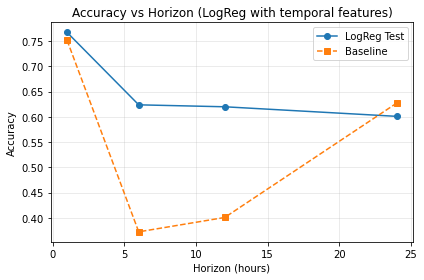

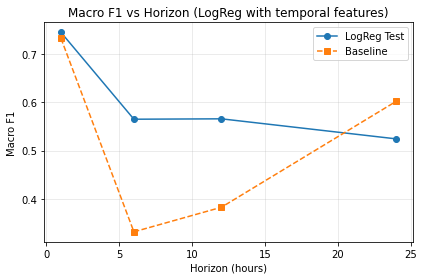

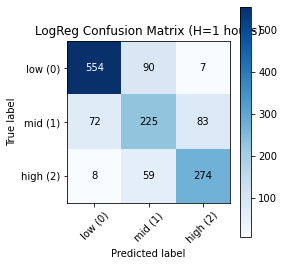

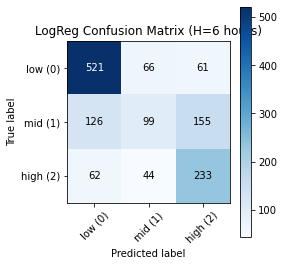

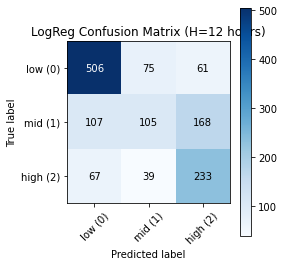

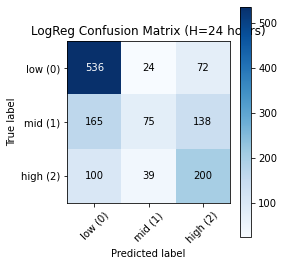

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

df_train = pd.read_csv("airq_train_fe.csv")
df_val   = pd.read_csv("airq_val_fe.csv")
df_test  = pd.read_csv("airq_test_fe.csv")

# CO Three-Class Categorization Function
def co_to_class(co_series):
    return pd.cut(
        co_series,
        bins=[-np.inf, 1.5, 2.5, np.inf],
        labels=[0, 1, 2]
    ).astype("Int64") 

HORIZONS = [1, 6, 12, 24]

def add_co_class_target(df, H):
    df = df.copy()
    df["CO_future"] = df["CO(GT)"].shift(-H)
    df["CO_class_target"] = co_to_class(df["CO_future"])
    return df

EXCLUDE_BASE = ["timestamp", "CO_future", "CO_class_target"]

def get_feature_cols(df_with_target):
    return [c for c in df_with_target.columns if c not in EXCLUDE_BASE]

log_metrics = []
log_conf_mats = {}

for H in HORIZONS:
    print("\n" + "="*60)
    print(f"Logistic Regression (with temporal features) for H = {H} hours")
    print("="*60)

    tr = add_co_class_target(df_train, H)
    vl = add_co_class_target(df_val, H)
    te = add_co_class_target(df_test, H)

    feature_cols = get_feature_cols(tr)

    X_train, y_train = tr[feature_cols], tr["CO_class_target"]
    X_val,   y_val   = vl[feature_cols], vl["CO_class_target"]
    X_test,  y_test  = te[feature_cols], te["CO_class_target"]

    # ignore label missing colums
    train_mask = y_train.notna()
    val_mask   = y_val.notna()
    test_mask  = y_test.notna()

    X_train, y_train = X_train[train_mask], y_train[train_mask].astype(int)
    X_val,   y_val   = X_val[val_mask],     y_val[val_mask].astype(int)
    X_test,  y_test  = X_test[test_mask],   y_test[test_mask].astype(int)

    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
        print(f"  Skipping H={H}: one of the splits is empty.")
        continue

    # mean value to fill the missing value
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_val   = imputer.transform(X_val)
    X_test  = imputer.transform(X_test)

    # standar scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)
    X_test  = scaler.transform(X_test)

    # Logistic Regression
    clf = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=2000,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)

    # valid
    val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    val_f1  = f1_score(y_val, val_pred, average="macro")
    print("\n[Validation]")
    print("  Accuracy:", val_acc)
    print("  Macro F1:", val_f1)

    # retrain
    X_train_full = np.vstack([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])
    clf.fit(X_train_full, y_train_full)

    # test
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_f1  = f1_score(y_test, test_pred, average="macro")
    cm       = confusion_matrix(y_test, test_pred)

    print("\n[Test]")
    print("  Accuracy:", test_acc)
    print("  Macro F1:", test_f1)
    print("  Confusion matrix:\n", cm)

    # baseline
    current_co_class = co_to_class(te["CO(GT)"])
    baseline_pred = current_co_class[test_mask]
    valid = baseline_pred.notna() & y_test.notna()
    if valid.any():
        y_true_baseline = y_test[valid].astype(int).to_numpy()
        y_pred_baseline = baseline_pred[valid].astype(int).to_numpy()
        baseline_acc = accuracy_score(y_true_baseline, y_pred_baseline)
        baseline_f1  = f1_score(y_true_baseline, y_pred_baseline, average="macro")
    else:
        baseline_acc = np.nan
        baseline_f1  = np.nan

    print("\n[Baseline]")
    print("  Accuracy:", baseline_acc)
    print("  Macro F1:", baseline_f1)

    log_metrics.append({
        "horizon": H,
        "val_acc": val_acc,
        "val_f1":  val_f1,
        "test_acc": test_acc,
        "test_f1":  test_f1,
        "baseline_acc": baseline_acc,
        "baseline_f1":  baseline_f1,
    })
    log_conf_mats[H] = cm


metrics_df = pd.DataFrame(log_metrics).sort_values("horizon")
Hs = metrics_df["horizon"].values

# Accuracy
plt.figure(figsize=(6,4))
plt.plot(Hs, metrics_df["test_acc"], marker="o", label="LogReg Test")
plt.plot(Hs, metrics_df["baseline_acc"], marker="s", linestyle="--", label="Baseline")
plt.xlabel("Horizon (hours)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Horizon (LogReg with temporal features)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro F1
plt.figure(figsize=(6,4))
plt.plot(Hs, metrics_df["test_f1"], marker="o", label="LogReg Test")
plt.plot(Hs, metrics_df["baseline_f1"], marker="s", linestyle="--", label="Baseline")
plt.xlabel("Horizon (hours)")
plt.ylabel("Macro F1")
plt.title("Macro F1 vs Horizon (LogReg with temporal features)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix
class_names = ["low (0)", "mid (1)", "high (2)"]

for H in HORIZONS:
    cm = log_conf_mats.get(H)
    if cm is None:
        continue

    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"LogReg Confusion Matrix (H={H} hours)")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
